In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from numba import njit
from tqdm import tqdm
sns.set_theme(style='ticks', context='notebook', font_scale=1.1)

## Section 1: Demographics

In [2]:
## Load data.
demo = read_csv(os.path.join('data', 's1', 'demographics.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 's1', 'reject.csv'))
demo = demo[demo.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)

### 1.1 Gender

In [3]:
## Count responses.
gb = demo.groupby('gender').subject.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
print(gb.set_index('gender').sort_values('count', ascending=False))

        count     %
gender             
Man        55  53.4
Woman      47  45.6
Other       1   1.0


### 1.2 Age

In [4]:
demo.age.describe().round(1)

count    103.0
mean      35.5
std       10.3
min       20.0
25%       28.5
50%       33.0
75%       41.0
max       69.0
Name: age, dtype: float64

#### Discretized

In [5]:
## Discretize ages.
demo['age_cat'] = np.digitize(demo.age, [29.5, 39.5, 49.5, 59.5])

## Count responses.
gb = demo.groupby('age_cat').subject.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
gb.index = ['18-29', '30-39', '40-49', '50-59', '60 and older']
print(gb[['count','%']])

              count     %
18-29            30  29.1
30-39            43  41.7
40-49            19  18.4
50-59             8   7.8
60 and older      3   2.9


### 1.3 Race & ethnicity

#### Ethnicity

In [6]:
## Count responses.
gb = demo.groupby('ethnicity').subject.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
print(gb.set_index('ethnicity').sort_values('count', ascending=False))

                        count     %
ethnicity                          
Not Hispanic or Latino     93  90.3
Hispanic or Latino          9   8.7
Rather not say              1   1.0


#### Race

In [7]:
## Count responses.
gb = demo.groupby('race').subject.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
print(gb.set_index('race').sort_values('count', ascending=False))

                           count     %
race                                  
White                         80  77.7
Asian                         10   9.7
Black or African American      9   8.7
Rather not say                 4   3.9


## Section 2: Behavior

In [8]:
## Load data.
data = concat([read_csv(os.path.join('data', session, 'pgng.csv'))
               for session in ['s1','s2','s3','s4']])

## Restrict participants.
reject = read_csv(os.path.join('data', 's1', 'reject.csv'))
data = data[data.subject.isin(reject.query('reject==0').subject)].reset_index(drop=True)

## Return number of participants per session.
print(data.groupby('session').subject.nunique())

session
1    103
2     94
3     92
4     89
Name: subject, dtype: int64


### 2.1 Learning curves

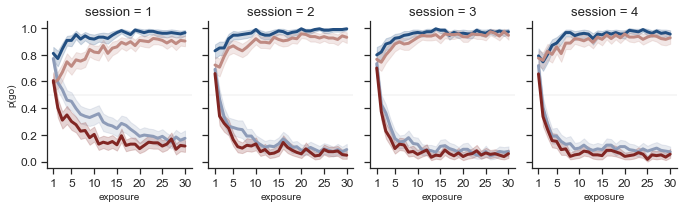

In [9]:
## Initialize canvas.
g = sns.FacetGrid(data, col='session', col_order=[1,2,3,4], aspect=0.8)

## Define aesthetics.
palette = ['#234f81', '#8e9cb8', '#bf8a82', '#812623']
hue_order = ['gw','ngw','gal','ngal']

## Plot learning curves.
g.map(sns.lineplot, 'exposure', 'choice', 'robot', hue_order=hue_order, palette=palette, 
      lw=3, errorbar=('ci', 95))

## Add trend line.
for ax in g.axes.flatten(): ax.axhline(0.5, color='k', alpha=0.05, zorder=-1)

## Adjust x-axis.
g.set(xticks=np.append(1, np.arange(5,31,5)))
g.set_xlabels('exposure')

## Adjust y-axis.
g.set_ylabels('p(go)');

### 2.2 Descriptive statistics

In [10]:
from itertools import combinations

## Define parameters.
n_iter = 5000
sessions = [1,2,3,4]
pairs = list(combinations(sessions, 2))

## Define convenience functions.
def mad(x):
    """Median absolute difference."""
    return np.nanmedian(np.abs(x - np.nanmedian(x)))

def cohens_d(x, popmean=0):
    """Cohen's D for one-sample median."""
    return np.abs(np.nanmedian(x) - popmean) / (mad(x) / 0.6745)

#### 2.2.1 Overall performance

**Within-session comparisons**

In [11]:
np.random.seed(47404)

## Compute average performance.
pivot = data.pivot_table('accuracy', 'subject', 'session')
pivot -= 0.5

## Compute observed effects.
obs = pivot.median().values

## Compute effect sizes.
d = pivot.apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute sign.
    pivot = pivot * np.random.choice([1,-1], pivot.shape, replace=True)
    
    ## Compute observed effects.
    null[n] = pivot.median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs + 0.5, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:05<00:00, 900.58it/s]


,obs,d,pval,fwer
session,,,,
1,0.850,2.982,0.0,0.122
2,0.929,6.947,0.0,0.000
3,0.946,10.310,0.0,0.000
4,0.946,12.029,0.0,0.000


**Between-session comparisons**

In [12]:
np.random.seed(47404)

## Compute average performance.
pivot = data.pivot_table('accuracy', 'subject', 'session')
pivot -= 0.5

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:19<00:00, 258.11it/s]


obs      d   pval   fwer
s1 s2                            
1  2  -0.056  0.792  0.000  0.000
   3  -0.065  0.909  0.000  0.000
   4  -0.058  0.858  0.000  0.000
2  3  -0.012  0.289  0.071  0.304
   4  -0.008  0.193  0.179  0.660
3  4  -0.004  0.112  0.513  0.982

#### 2.2.2 Main effect: required action

**Within-session comparisons**

In [13]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'action')

## Compute observed effects.
obs = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['go'] - pivot['no-go']).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:44<00:00, 111.55it/s]


,obs,d,pval,fwer
session,,,,
1,0.117,1.049,0.0,0.000
2,0.050,1.156,0.0,0.000
3,0.042,1.124,0.0,0.007
4,0.033,0.899,0.0,0.040


**Between-session comparisons**

In [14]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', ['action','session'])
pivot = pivot['go'] - pivot['no-go']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:19<00:00, 253.13it/s]


obs      d   pval   fwer
s1 s2                            
1  2   0.025  0.337  0.000  0.001
   3   0.054  0.674  0.000  0.000
   4   0.075  0.674  0.000  0.000
2  3   0.013  0.289  0.068  0.305
   4   0.025  0.506  0.000  0.001
3  4   0.008  0.225  0.122  0.519

#### 2.2.3 Main effect: outcome valence

**Within-session comparisons**

In [15]:
np.random.seed(47404)

## Compute average performance by outcome valence.
pivot = data.pivot_table('accuracy', ['session','subject'], 'valence')

## Compute observed effects.
obs = (pivot['win'] - pivot['lose']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['win'] - pivot['lose']).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['win'] - pivot['lose']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:44<00:00, 112.24it/s]


,obs,d,pval,fwer
session,,,,
1,0.008,0.135,0.070,0.186
2,0.008,0.169,0.023,0.063
3,0.000,0.000,0.265,0.880
4,0.000,0.000,0.264,0.880


**Between-session comparisons**

In [16]:
np.random.seed(47404)

## Compute average performance by outcome valence.
pivot = data.pivot_table('accuracy', 'subject', ['valence','session'])
pivot = pivot['win'] - pivot['lose']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:20<00:00, 244.35it/s]


obs      d   pval   fwer
s1 s2                            
1  2  -0.004  0.045  0.578  0.994
   3   0.000  0.000  0.743  1.000
   4   0.008  0.096  0.298  0.844
2  3   0.008  0.169  0.264  0.796
   4   0.008  0.123  0.300  0.844
3  4   0.000  0.000  0.747  1.000

#### 2.2.4 Interaction effect: action type X outcome valence

**Within-session comparisons**

In [17]:
np.random.seed(47404)

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', ['session','subject'], 'congruence')

## Compute observed effects.
obs = (pivot['c'] - pivot['i']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['c'] - pivot['i']).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['c'] - pivot['i']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:43<00:00, 113.77it/s]


,obs,d,pval,fwer
session,,,,
1,0.092,1.237,0.000,0.000
2,0.017,0.450,0.000,0.107
3,0.017,0.450,0.000,0.165
4,0.008,0.225,0.002,0.193


**Between-session comparisons**

In [18]:
np.random.seed(47404)

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', 'subject', ['congruence','session'])
pivot = pivot['c'] - pivot['i']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((obs[:,np.newaxis] < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:21<00:00, 235.49it/s]


obs      d   pval   fwer
s1 s2                            
1  2   0.046  0.495  0.000  0.000
   3   0.067  0.899  0.000  0.000
   4   0.075  0.867  0.000  0.000
2  3   0.008  0.169  0.265  0.814
   4   0.017  0.270  0.052  0.290
3  4   0.004  0.096  0.671  0.998

#### 2.2.5 Secondary effect: feedback type 

**Within-session comparisons**

In [19]:
## Define previous exposure.
data['prev_sham'] = data.groupby(['subject','session','stimulus']).sham.transform(np.roll, 1)
data.loc[data.exposure == 1, 'prev_sham'] = np.nan

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'prev_sham')

## Compute observed effects.
obs = (pivot[0] - pivot[1]).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot[0] - pivot[1]).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot[0] - pivot[1]).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:44<00:00, 112.59it/s]


,obs,d,pval,fwer
session,,,,
1,0.094,1.250,0.0,0.000
2,0.045,0.770,0.0,0.001
3,0.030,0.581,0.0,0.091
4,0.028,0.704,0.0,0.181


**Between-session comparisons**

In [20]:
np.random.seed(47404)

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', 'subject', ['prev_sham','session'])
pivot = pivot[0] - pivot[1]

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:21<00:00, 234.86it/s]


obs      d   pval   fwer
s1 s2                            
1  2   0.038  0.492  0.000  0.000
   3   0.039  0.572  0.000  0.000
   4   0.053  0.777  0.000  0.000
2  3   0.008  0.137  0.286  0.833
   4   0.019  0.326  0.034  0.188
3  4   0.011  0.201  0.171  0.622

#### 2.2.6 Secondary effect: scanner color

**Overall accuracy**

In [50]:
## Compute average performance by scanner color.
pivot = data.pivot_table('accuracy', ['session','subject'], 'color')

## Compute observed effects.
obs = (pivot['blue'] - pivot['yellow']).median()

## Compute effect sizes.
d = cohens_d(pivot['blue'] - pivot['yellow'])

## Compute null distribution.
null = np.zeros(n_iter)
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['blue'] - pivot['yellow']).median()
    
## Compute p-values.
pval = ((np.abs(obs) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

## Report summary.
print('obs = %0.3f (d = %0.3f, p = %0.3f)' %(obs, d, pval))

100%|██████████| 5000/5000 [00:47<00:00, 105.46it/s]

obs = 0.000 (d = 0.000, p = 0.077)


### 2.3 Individual-differences

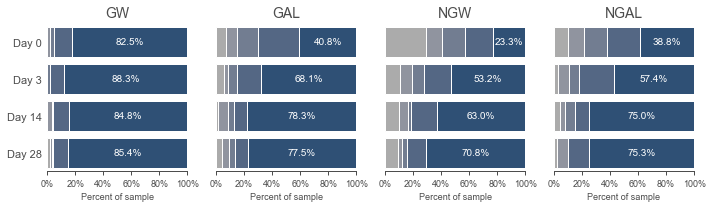

In [21]:
## Compute accuracy by participant / session / condition.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()

## Score performance into top five deciles.
gb['score'] = np.digitize(gb.accuracy, np.arange(0.6,1.0,0.1))

## Calculate proportion of participants in each bin.
gb = gb.groupby(['robot','session','score']).subject.count().reset_index()
gb['prop'] = gb.groupby(['robot','session']).subject.transform(lambda x: x / x.sum())
gb['cumprop'] = gb.groupby(['robot','session']).prop.transform(np.cumsum)

## Initialize canvas.
fig, axes = plt.subplots(1, 4, figsize=(10,3))
palette = sns.color_palette('crest_r', n_colors=gb.score.nunique()).as_hex()
palette = ['#234f81', '#4c658c', '#6d7b96', '#8d93a1', '#ababab']

## Iteratively plot.
for i, (ax, robot) in enumerate(zip(axes, ['gw','gal','ngw','ngal'])):

    ## Stacked barchart. 
    for score, color in zip(np.unique(gb.score)[::-1], palette):    
    
        ## Plot scores.
        q = f'robot == "{robot}" and score == {score}'
        sns.barplot(x='cumprop', y='session', data=gb.query(q), order=[1,2,3,4], 
                    palette=np.repeat(color, 4), orient='h', ax=ax)
    
    ## Annotations.
    for y, session in enumerate([1,2,3,4]):
        v = gb.set_index(['robot','session','score']).loc[(robot,session,4)].prop
        ax.annotate('%0.1f%%' %(v*1e2), (0,0), (1-v/2, y), ha='center', va='center',
                    color='w', fontsize=10)
    
    ## Adjust x-axis.
    ax.set(xlim=(0,1), xticks=np.linspace(0,1,6))
    ax.set_xticklabels(['%0.0f%%' %p for p in np.linspace(0,1e2,6)], fontsize=9, color='0.3')
    ax.set_xlabel('Percent of sample', fontsize=9, color='0.3')

    ## Adjust y-axis.
    ax.set(ylabel='', yticks=np.arange(4), yticklabels=[])
    if not i: ax.set_yticklabels(['Day 0', 'Day 3', 'Day 14', 'Day 28'], ha='right',
                                 fontsize=11, color='0.3')
    
    ## Adjust title.
    ax.set_title(robot.upper(), fontsize=14, color='0.3')
    
    ## Modify ax spines.
    ax.yaxis.set_tick_params(pad=1)
    ax.spines['bottom'].set(linewidth=1, color='0.3')
    ax.tick_params(bottom=True, left=False, color='0.3', length=4, width=1)
    sns.despine(ax=ax, left=True, right=True, top=True, bottom=False)
    
plt.tight_layout()

In [154]:
from scipy.stats import chi2_contingency

## Compute accuracy by participant / session / condition.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()

## Score performance into top five deciles.
gb['score'] = np.digitize(gb.accuracy, [0.6,0.9])

## Calculate proportion of participants in each bin.
pivot = gb.pivot_table('subject', ['robot','score'], 'session', aggfunc='count').fillna(0)

for robot in ['gw','ngw','gal','ngal']:
    chi2, pval, dof, _ = chi2_contingency(pivot.loc[robot])
    print('%s\tx2(df=%s) = %0.3f (p = %0.3f)' %(robot, dof, chi2, pval))

gw	x2(df=6) = 8.149 (p = 0.227)
ngw	x2(df=6) = 55.458 (p = 0.000)
gal	x2(df=6) = 42.191 (p = 0.000)
ngal	x2(df=6) = 39.287 (p = 0.000)
